In [1]:
from BIDS import BIDS_Global_info, BIDS_Family

In [2]:
#Lets import the class that represent a whole data set.
from BIDS import BIDS_Global_info, BIDS_Family
# You can parse multiple datasets and select what parent folder are read (e.g. rawdata, derivatives)
bids_global_object = BIDS_Global_info(['/data1/practical-sose23/dataset-verse19',  '/data1/practical-sose23/dataset-verse20'],['rawdata',"derivatives"], additional_key = ["ct", "subreg", "cortex"], verbose=True)
#The Parser will inform you about every non standard files. To add additional key add them to additional_key list, so you don't get the msg that this is not a valid key
from BIDS.snapshot2D import create_snapshot,Snapshot_Frame,Visualization_Type,Image_Modes
from pathlib import Path
from IPython.display import Image

[!] Unknown format seg-ano in file sub-verse649_dir-sag_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] Unknown format subreg in file sub-verse559_CT-sag_seg-ano_subreg.nii.gz


## Masterlist Understanding
Let's have a look at the master file and extract informations related to dataset

In [6]:
import pandas as pd
gt_df = pd.read_excel('../dataset/VerSe_masterlist.xlsx', index_col=0)
gt_df.head()

,Full_Id,Castellvi,2a/3a Side,Sacrum Seg,Last_L,Split,Comment
Id,,,,,,,
4,sub-verse004,0,NaN,1.0,L5,NaN,NaN
5,sub-verse005,0,NaN,1.0,L5,NaN,NaN
6,sub-verse006,0,NaN,1.0,L5,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,sub-verse008,0,NaN,1.0,L5,NaN,NaN


In [7]:
print("Number of rows: {}".format(len(gt_df.index)))
print("Number of null rows: {}".format(gt_df["Full_Id"].isnull().sum()))

Number of rows: 325
Number of null rows: 40


In [8]:
# print out the files that does not have information in masterlist
null_indexes = gt_df.index[gt_df["Full_Id"].isnull()].tolist()
print("Null row indexes: {}".format(null_indexes))


Null row indexes: [7, 11, 12, 18, 59, 75, 81, 100, 105, 112, 119, 125, 150, 205, 207, 217, 221, 225, 230, 242, 250, 544, 596, 640, 641, 643, 645, 647, 648, 650, 651, 707, 710, 754, 756, 757, 764, 767, 803, 814]


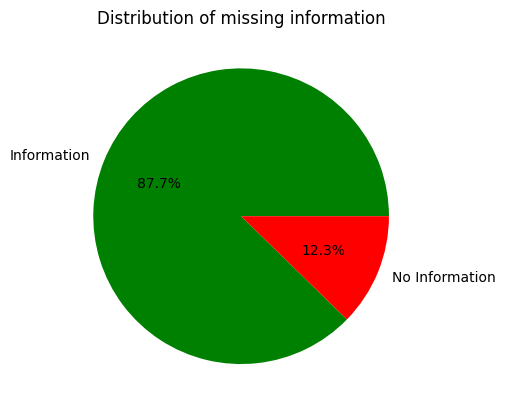

In [13]:
# plot those missing information distribution over the dataset
import matplotlib.pyplot as plt


null_count = gt_df["Full_Id"].isnull().sum()
non_null_count = len(gt_df) - null_count
labels = ["Information", "No Information"]
values = [non_null_count, null_count]
colors = ["green", "red"]

plt.pie(values, labels=labels, colors=colors, autopct="%1.1f%%")
plt.title("Distribution of missing information" , loc='center')
plt.show()



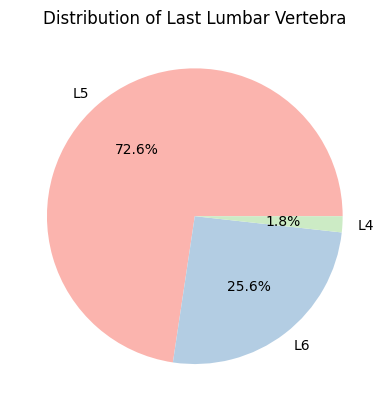

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the count of Last_L values for the entire dataset
last_l_counts = gt_df['Last_L'].value_counts().reset_index()

# Rename columns for better readability
last_l_counts.columns = ['Last_L', 'Count']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(last_l_counts['Count'], labels=last_l_counts['Last_L'], autopct="%1.1f%%", colors=plt.cm.Pastel1.colors)
ax.set_title('Distribution of Last Lumbar Vertebra')

plt.show()


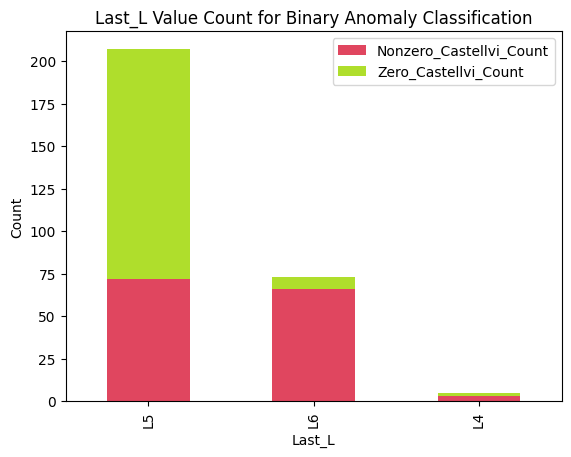

In [16]:
# plot the binary class distribution

# Filter the rows with Castellvi different than 0
castellvi_nonzero = gt_df[gt_df['Castellvi'] != 0]

# Filter the rows with Castellvi equal to 0
castellvi_zero = gt_df[gt_df['Castellvi'] == 0]

# Calculate the count of Last_L values for each group
castellvi_nonzero_count = castellvi_nonzero['Last_L'].value_counts().reset_index()
castellvi_zero_count = castellvi_zero['Last_L'].value_counts().reset_index()

# Rename columns for better readability
castellvi_nonzero_count.columns = ['Last_L', 'Nonzero_Castellvi_Count']
castellvi_zero_count.columns = ['Last_L', 'Zero_Castellvi_Count']

# Merge the two count DataFrames on the Last_L column
merged_counts = pd.merge(castellvi_nonzero_count, castellvi_zero_count, on='Last_L')

# Create the bar chart
fig, ax = plt.subplots()
merged_counts.plot(x='Last_L', kind='bar', stacked=True, ax=ax, color=['#e0465f', '#afde2c'])
ax.set_title('Last_L Value Count for Binary Anomaly Classification')
ax.set_xlabel('Last_L')
ax.set_ylabel('Count')
plt.show()


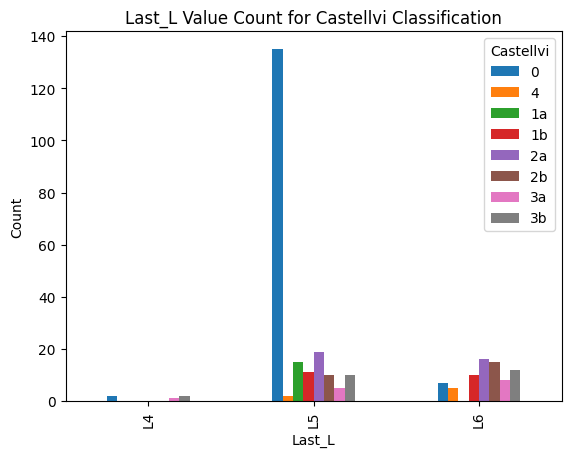

In [18]:
# Let's plot the sub_classes distribution
# Group by Castellvi and Last_L values and calculate the count
grouped_counts = gt_df.groupby(['Castellvi', 'Last_L']).size().reset_index(name='Count')

# Rename columns for better readability
grouped_counts.columns = ['Castellvi', 'Last_L', 'Count']

# Create the grouped bar chart
fig, ax = plt.subplots()
grouped_counts.pivot(index='Last_L', columns='Castellvi', values='Count').plot(kind='bar', stacked=False, ax=ax)
ax.set_title('Last_L Value Count for Castellvi Classification')
ax.set_xlabel('Last_L')
ax.set_ylabel('Count')
plt.show()

## BIDS Families

IDS splits data samples roughly into:
- Subject: different patients
- Sessions: one patient can have multiple scans

You use enumerate_subjects to iterate over different, unique subjects.
Then, you can use queries to apply various filters. If you use flatten=True, that means you filter inividual files, and not a group/family of files.


Everyone needs a family! 
Files that are generated from others should belong to a family. We automatically find related files and cluster them into a dictionary.


In [28]:
#Let's get a few basic statistics about our data set first
print(len(bids_global_object.subjects))

bids_families = []
fam_count = {}
for subject_name, subject_container in bids_global_object.enumerate_subjects(sort = True):

    query = subject_container.new_query(flatten=False) #<- flatten=False means we search for family
    #For the project, we need a ct scan, a segmentation and the centroid data. So let's filter for that
    query.filter('format','ct')
    query.filter('seg','vert')

    i = 0

    #now we can loop over families and gather some information
    for bids_family in query.loop_dict(sort=True):
        bids_families.append(bids_family)
        i = i + 1

    
    fam_count[query.subject.name] = i
        

print(len(bids_families))
print(fam_count)
    

323
342
{'verse004': 1, 'verse005': 1, 'verse006': 1, 'verse007': 1, 'verse008': 1, 'verse009': 1, 'verse010': 1, 'verse011': 1, 'verse012': 1, 'verse013': 1, 'verse014': 1, 'verse015': 1, 'verse016': 1, 'verse018': 1, 'verse020': 1, 'verse022': 1, 'verse023': 1, 'verse024': 1, 'verse026': 1, 'verse029': 1, 'verse030': 1, 'verse031': 1, 'verse032': 1, 'verse033': 1, 'verse034': 1, 'verse036': 1, 'verse038': 1, 'verse040': 1, 'verse041': 1, 'verse043': 1, 'verse046': 1, 'verse047': 1, 'verse048': 1, 'verse050': 1, 'verse051': 1, 'verse053': 1, 'verse054': 1, 'verse055': 1, 'verse056': 1, 'verse058': 1, 'verse059': 1, 'verse060': 1, 'verse061': 1, 'verse063': 1, 'verse064': 1, 'verse065': 1, 'verse066': 1, 'verse067': 1, 'verse068': 1, 'verse070': 1, 'verse071': 1, 'verse072': 1, 'verse073': 1, 'verse074': 1, 'verse075': 1, 'verse076': 1, 'verse078': 1, 'verse080': 1, 'verse081': 1, 'verse082': 1, 'verse083': 1, 'verse085': 1, 'verse088': 1, 'verse089': 1, 'verse091': 1, 'verse092': 1, '

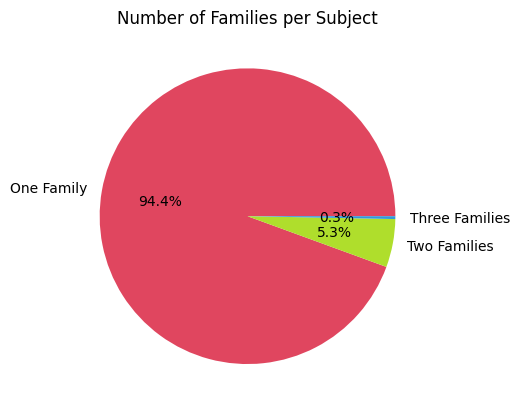

In [23]:
# There are a total of 323 subjects. All but 18 have exactly one family. 18 of these have more than one family (verse400 - verse417), with two each, except for verse 405 which has 3 families.


# Count the number of subjects with one, two, and three families
num_subjects_with_one_family = num_families.count(1)
num_subjects_with_two_families = num_families.count(2)
num_subjects_with_three_families = num_families.count(3)

# Create a list of labels for the pie chart
labels = ['One Family', 'Two Families', 'Three Families']

# Create a list of values for the pie chart
values = [num_subjects_with_one_family, num_subjects_with_two_families, num_subjects_with_three_families]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=['#e0465f', '#afde2c', '#3498db'])
ax.set_title('Number of Families per Subject')

plt.show()



In [25]:
# print out the subjects that have more than one family
[gt_df["Full_Id"][i] for i in range(400,418)]

['sub-verse400_split-verse155',
 'sub-verse401_split-verse253',
 'sub-verse402_split-verse251',
 'sub-verse403_split-verse255',
 'sub-verse404_split-verse256',
 'sub-verse405_split-verse259',
 'sub-verse406_split-verse261',
 'sub-verse407_split-verse262',
 'sub-verse408_split-verse265',
 'sub-verse409_split-verse266',
 'sub-verse410_split-verse267',
 'sub-verse411_split-verse270',
 'sub-verse412_split-verse290',
 'sub-verse413_split-verse272',
 'sub-verse414_split-verse273',
 'sub-verse415_split-verse275',
 'sub-verse416_split-verse279',
 'sub-verse417_split-verse278']

## Data Visualization

[*] Snapshot saved: /tmp/snap.jpg


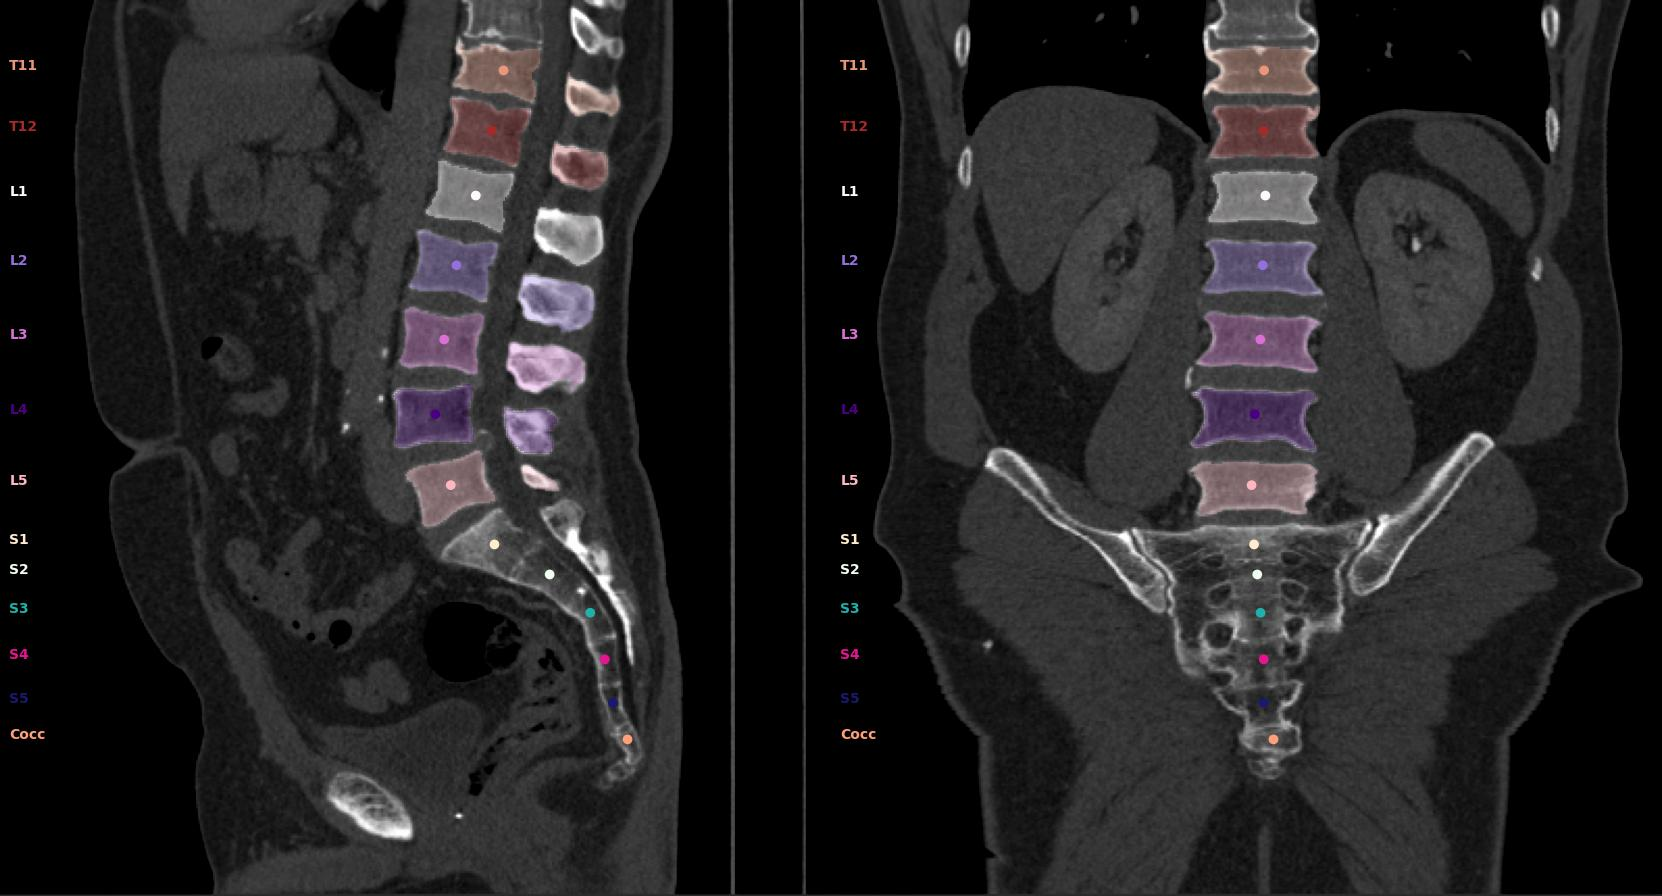

In [26]:
ct_file = bids_family["ct"][0].file["nii.gz"]
vert_file = bids_family["msk_seg-vert"][0].file["nii.gz"]
ctd_file = bids_family["ctd_seg-subreg"][0].file["json"]
out_file = "/tmp/snap.jpg"
ct_frame = Snapshot_Frame(ct_file,segmentation=vert_file,centroids=ctd_file,sagittal=True,coronal=True,mode='CT')
create_snapshot(out_file,[ct_frame])
Image(filename=out_file) 